In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

from src.data_prep.Nifty50Dataset import Nifty50Dataset
from src.forecasting.GaussianTransformer import CustomTransformerEncoderOnly
from src.forecasting.StockSeriesForcaster import StockSeriesForecaster
from src.forecasting.StockSeriesForcasterEncoder import StockSeriesForecasterEncoder

model = CustomTransformerEncoderOnly(d_model=4, nhead=2, num_encoder_layers=6, dim_feedforward=256)

dataset = Nifty50Dataset(
    "/Users/maniksomayaji/Documents/omscs/capstone_project/data/NIFTY 50_minute_data.csv",
    window_size=300,
    prediction_horizon=1
)

split_ratio = 0.1
val_size = int(len(dataset) * split_ratio)
test_size = int(len(dataset) * split_ratio)
train_size = len(dataset) - 2 * val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

forecaster = StockSeriesForecasterEncoder(model, optimizer, criterion)


In [ ]:
train_loss, val_loss = forecaster.train(train_loader, val_loader, epochs=10)

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

[Epoch 1 | Batch 50] Loss: 1.1828
[Epoch 1 | Batch 100] Loss: 0.8331
[Epoch 1 | Batch 150] Loss: 0.1832
[Epoch 1 | Batch 200] Loss: 5.6999
[Epoch 1 | Batch 250] Loss: 4.6442
[Epoch 1 | Batch 300] Loss: 0.2650
[Epoch 1 | Batch 350] Loss: 0.2916
[Epoch 1 | Batch 400] Loss: 1.3173
[Epoch 1 | Batch 450] Loss: 1.0542
[Epoch 1 | Batch 500] Loss: 0.9510
[Epoch 1 | Batch 550] Loss: 0.0989
[Epoch 1 | Batch 600] Loss: 0.5215
[Epoch 1 | Batch 650] Loss: 1.2959
[Epoch 1 | Batch 700] Loss: 2.0403
[Epoch 1 | Batch 750] Loss: 0.2073
[Epoch 1 | Batch 800] Loss: 0.3800
[Epoch 1 | Batch 850] Loss: 1.7432
[Epoch 1 | Batch 900] Loss: 0.1740
[Epoch 1 | Batch 950] Loss: 1.1532
[Epoch 1 | Batch 1000] Loss: 0.8795
[Epoch 1 | Batch 1050] Loss: 0.2896
[Epoch 1 | Batch 1100] Loss: 0.1080
[Epoch 1 | Batch 1150] Loss: 1.9692
[Epoch 1 | Batch 1200] Loss: 0.7030
[Epoch 1 | Batch 1250] Loss: 2.6585
[Epoch 1 | Batch 1300] Loss: 0.3225
[Epoch 1 | Batch 1350] Loss: 2.8131
[Epoch 1 | Batch 1400] Loss: 1.7757
[Epoch 1 | B

In [3]:
num_batches = 3
for i, (x, y) in enumerate(train_loader):
    if i >= num_batches:
        break
    output = forecaster.autoregressive_predict(x, max_len=20)
    print("Generated:", output)

Generated: tensor([[8116.2197, 8118.7080, 8122.7983, 8128.6309, 8134.4897, 8140.2163,
         8142.8833, 8143.8892, 8144.3604, 8144.6948, 8144.9907, 8145.2705,
         8145.5254, 8145.7568, 8145.9678, 8146.1523, 8146.3228, 8146.4858,
         8146.6392, 8146.7832],
        [8167.6182, 8162.5425, 8157.7510, 8157.4624, 8157.3857, 8157.2773,
         8157.1865, 8157.0972, 8157.0146, 8156.9360, 8156.8633, 8156.7949,
         8156.7305, 8156.6733, 8156.6206, 8156.5723, 8156.5269, 8156.4844,
         8156.4448, 8156.4082]])
Generated: tensor([[7985.8784, 7986.9888, 7987.4043, 7987.6499, 7987.8574, 7988.0488,
         7988.2271, 7988.3926, 7988.5454, 7988.6865, 7988.8179, 7988.9404,
         7989.0542, 7989.1602, 7989.2588, 7989.3511, 7989.4365, 7989.5166,
         7989.5908, 7989.6577],
        [8368.7959, 8367.6387, 8365.9072, 8358.4336, 8334.1787, 8352.2334,
         8353.6924, 8356.1455, 8359.7510, 8364.0537, 8366.1221, 8367.2969,
         8368.3320, 8369.3281, 8370.2803, 8371.1123, 837

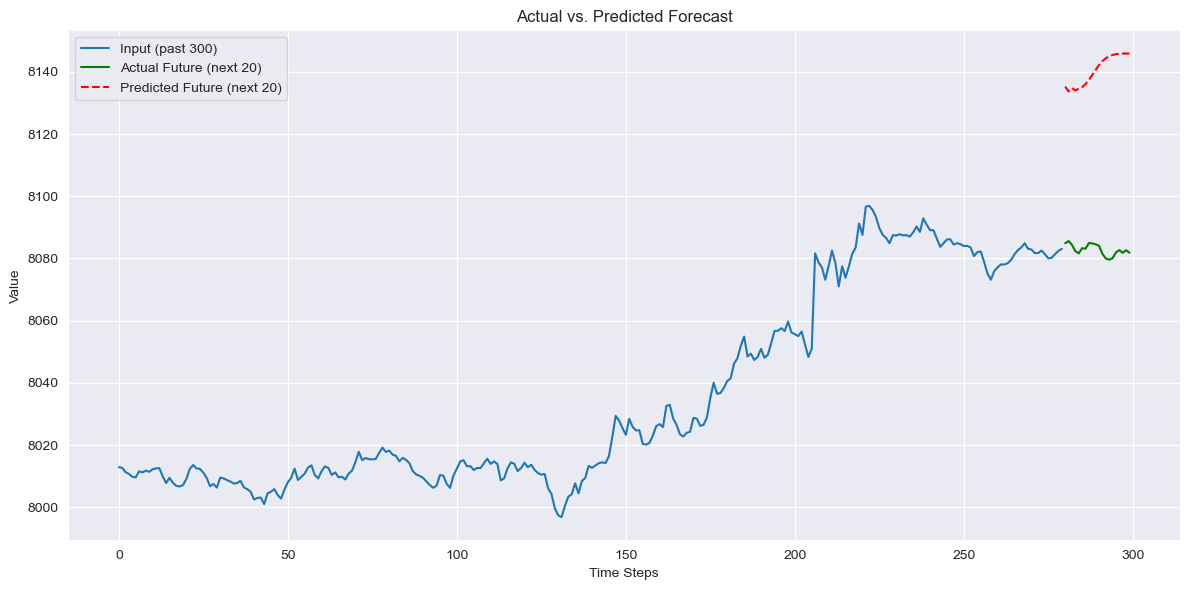

In [4]:
import matplotlib.pyplot as plt
import torch

data_x, data_y = val_dataset[200]
full_series = data_x[:320]

input_seq = full_series[:280].unsqueeze(0)
true_future = full_series[280:]

with torch.no_grad():
    predicted_future = forecaster.autoregressive_predict(input_seq, max_len=20)
predicted_future = predicted_future.squeeze().unsqueeze(-1) # Remove batch dimension

plt.figure(figsize=(12, 6))
plt.plot(range(280), input_seq.squeeze(), label='Input (past 300)')
plt.plot(range(280, 300), true_future, label='Actual Future (next 20)', color='green')
plt.plot(range(280, 300), predicted_future, label='Predicted Future (next 20)', color='red', linestyle='--')
plt.legend()
plt.title('Actual vs. Predicted Forecast')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
torch.save(model.state_dict(), 'model_l_1.pth')

In [12]:
forecaster1 = StockSeriesForecaster(model, optimizer, criterion)
train_loss, val_loss = forecaster1.train(train_loader, val_loader)

KeyboardInterrupt: 

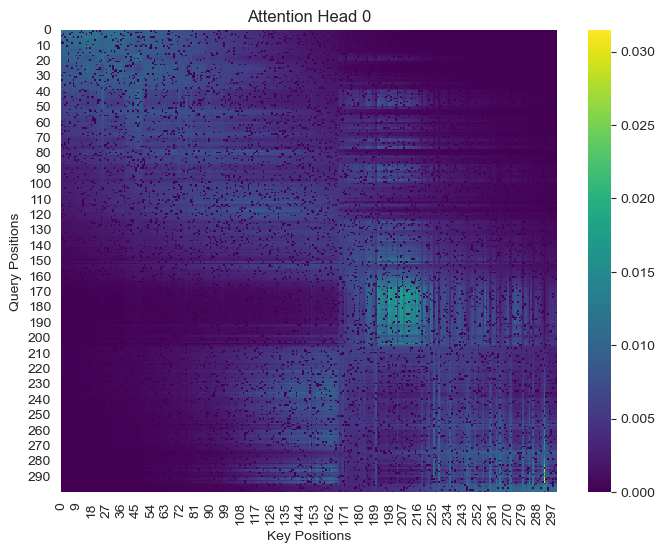

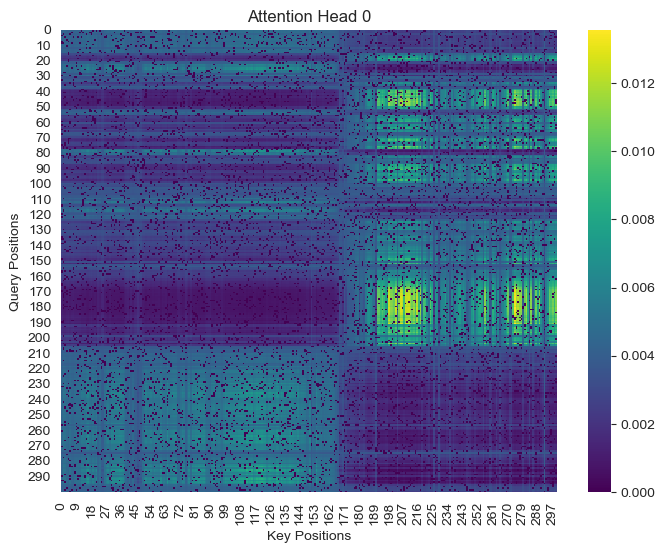

In [5]:
first_encoder_layer = model.encoder.layers[2]
attn_weights = first_encoder_layer.self_attn.guass_attn_weights_for_plot
raw_attn_weights = first_encoder_layer.self_attn.raw_attn_weights_for_plot

import matplotlib.pyplot as plt
import seaborn as sns

# Pick the first head
head_id = 0
attention = attn_weights[0, head_id].numpy()  # shape: (Tq, Tk)

plt.figure(figsize=(8, 6))
sns.heatmap(attention, cmap="viridis")
plt.title(f"Attention Head {head_id}")
plt.xlabel("Key Positions")
plt.ylabel("Query Positions")
plt.show()

head_id = 0
raw_attention = raw_attn_weights[0, head_id].numpy()

plt.figure(figsize=(8, 6))
sns.heatmap(raw_attention, cmap="viridis")
plt.title(f"Attention Head {head_id}")
plt.xlabel("Key Positions")
plt.ylabel("Query Positions")
plt.show()

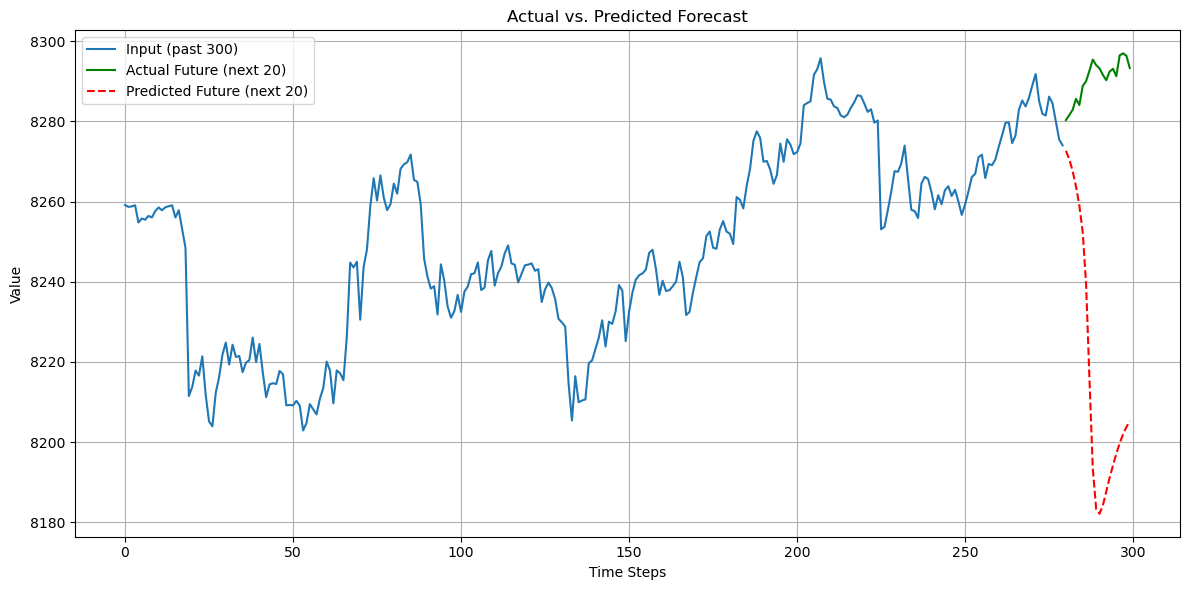